<a href="https://colab.research.google.com/github/micah-shull/Statistics/blob/main/Statistics_28_hypothesis_testing_cars_weight_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Question**:
Is the average weight of cars the same across origin groups (USA, Europe, Japan)?

---

### **Hypotheses**:
- **Null Hypothesis (H₀):**  
  The mean weight of cars is the same across all origin groups (USA, Europe, and Japan).  
  *In other words, origin has no effect on the mean weight of cars.*

- **Alternative Hypothesis (H₁):**  
  At least one origin group has a different mean weight.  
  *In other words, the mean weight differs between at least two origins.*



In [30]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

# Load the dataset
cars = sns.load_dataset('mpg')

# Print the number of unique values for each column
unique_counts = cars.nunique()

# Define a threshold for unique values to classify as categorical
threshold = 10

# Identify columns to convert to categorical
categorical_cols = unique_counts[unique_counts < threshold].index.tolist()

# Convert suitable columns to category
for col in categorical_cols:
    cars[col] = cars[col].astype('category')

# Verify the changes
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           398 non-null    float64 
 1   cylinders     398 non-null    category
 2   displacement  398 non-null    float64 
 3   horsepower    392 non-null    float64 
 4   weight        398 non-null    int64   
 5   acceleration  398 non-null    float64 
 6   model_year    398 non-null    int64   
 7   origin        398 non-null    category
 8   name          398 non-null    object  
dtypes: category(2), float64(4), int64(2), object(1)
memory usage: 23.0+ KB
None


In [13]:
from scipy.stats import f_oneway

# Group the data by origin
usa_weight = cars[cars['origin'] == 'usa']['weight']
europe_weight = cars[cars['origin'] == 'europe']['weight']
japan_weight = cars[cars['origin'] == 'japan']['weight']

# Perform One-Way ANOVA
f_stat, p_value = f_oneway(usa_weight, europe_weight, japan_weight)

# Print the results
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the Null Hypothesis: At least one origin group has a different mean weight.")
else:
    print("Fail to Reject the Null Hypothesis: Mean weight is the same across all origin groups.")


F-Statistic: 112.74
P-Value: 0.0000
Reject the Null Hypothesis: At least one origin group has a different mean weight.


### **Interpretation of the Results**

1. **F-Statistic: 112.74**  
   - This large F-statistic indicates that the variability **between the group means** (differences in mean weights for USA, Europe, and Japan) is much larger than the variability **within the groups**.

2. **P-Value: 0.0000**  
   - The p-value is effectively zero, far below the standard significance level (\( \alpha = 0.05 \)).
   - This means the observed differences in mean weights across the origin groups are **highly statistically significant**.

3. **Decision**:  
   - Since the p-value is smaller than \( \alpha = 0.05 \), we **reject the null hypothesis**.
   - Conclusion: At least one origin group has a significantly different mean weight compared to the others.





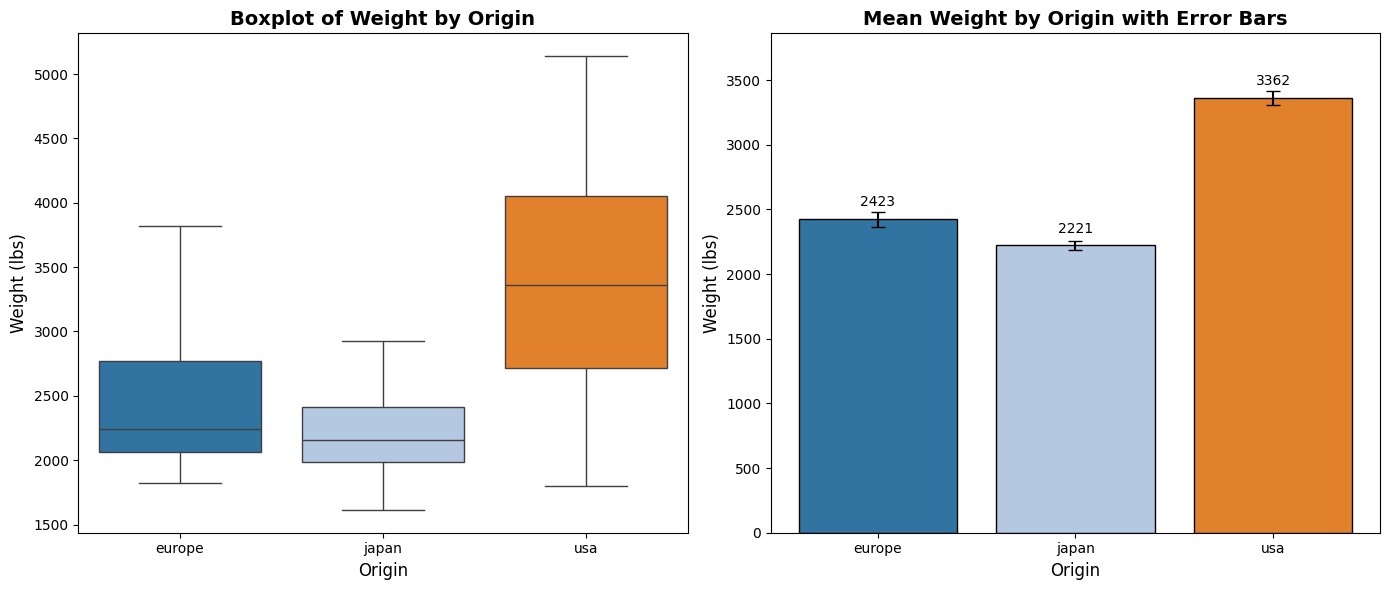

In [25]:
# Calculate the means and standard deviations for each origin group
group_stats = cars.groupby('origin', observed=True)['weight'].agg(['mean', 'std', 'count']).reset_index()
group_stats['error'] = group_stats['std'] / group_stats['count']**0.5  # Standard error of the mean

# Define the color palette
palette = sns.color_palette("tab20", n_colors=3)

# Set up the figure with a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Boxplot
sns.boxplot(data=cars, x='origin', y='weight', hue='origin', palette=palette, ax=axes[0])
axes[0].set_title('Boxplot of Weight by Origin', fontsize=14, weight='bold')
axes[0].set_xlabel('Origin', fontsize=12)
axes[0].set_ylabel('Weight (lbs)', fontsize=12)

# Plot 2: Barplot with Error Bars
sns.barplot(data=group_stats, x='origin', y='mean', hue='origin', palette=palette, ax=axes[1], edgecolor='black', errorbar=None)

# Add error bars to the barplot
for index, row in group_stats.iterrows():
    axes[1].errorbar(x=index, y=row['mean'], yerr=row['error'], fmt='none', c='black', capsize=5)

# Add data labels to the barplot
for index, row in group_stats.iterrows():
    axes[1].text(index, row['mean'] + 100, f"{row['mean']:.0f}", ha='center', fontsize=10)

axes[1].set_title('Mean Weight by Origin with Error Bars', fontsize=14, weight='bold')
axes[1].set_xlabel('Origin', fontsize=12)
axes[1].set_ylabel('Weight (lbs)', fontsize=12)
axes[1].set_ylim(0, group_stats['mean'].max() + 500)  # Adjust y-axis for labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### **Interpretation of Tukey’s HSD Results**

#### **Key Outputs**:
1. **Europe vs. Japan**:
   - **Mean Difference**: -202.07 (Europe cars weigh less than Japan cars, on average).
   - **P-Value**: 0.1652 (not significant, \( p > 0.05 \)).
   - **Conclusion**: There is **no significant difference** in the mean weight of cars between Europe and Japan.

2. **Europe vs. USA**:
   - **Mean Difference**: 938.63 (USA cars weigh significantly more than Europe cars, on average).
   - **P-Value**: 0.0000 (highly significant, \( p < 0.05 \)).
   - **Conclusion**: Cars from the USA are significantly **heavier** than those from Europe.

3. **Japan vs. USA**:
   - **Mean Difference**: 1140.70 (USA cars weigh significantly more than Japan cars, on average).
   - **P-Value**: 0.0000 (highly significant, \( p < 0.05 \)).
   - **Conclusion**: Cars from the USA are significantly **heavier** than those from Japan.

---

### **Key Insights**:
- **USA cars** are the **heaviest** on average, significantly heavier than both Europe and Japan cars.
- **Europe and Japan cars** have similar average weights, with no statistically significant difference.



In [26]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=cars['weight'], groups=cars['origin'], alpha=0.05)

# Print the results
print(tukey)

# Convert results to a DataFrame for easier readability
tukey_results = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
tukey_results.columns = ['Group 1', 'Group 2', 'Mean Diff', 'Lower CI', 'Upper CI', 'P-Value', 'Reject']

# # Display the Tukey results
# print("\nTukey’s HSD Results:")
# print(tukey_results)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
europe  japan -202.0722 0.1652 -463.6533    59.509  False
europe    usa  938.6317    0.0  723.0447 1154.2187   True
 japan    usa 1140.7039    0.0  934.9256 1346.4822   True
---------------------------------------------------------


To better understand the **Tukey HSD results** table and identify key insights, you should focus on the following components:

---

### **How to Read the Tukey HSD Results Table**:

1. **Group Comparisons (`group1` vs. `group2`)**:
   - This column shows which two groups are being compared. Each row represents one pairwise comparison.

2. **Mean Difference (`meandiff`)**:
   - The average difference between the means of the two groups being compared.
   - Positive values indicate that the first group (`group1`) has a higher mean than the second group (`group2`).
   - Negative values indicate that the second group (`group2`) has a higher mean than the first group (`group1`).

3. **P-Adjusted (`p-adj`)**:
   - The **adjusted p-value** accounts for multiple comparisons, ensuring that the overall family-wise error rate is controlled (to reduce the risk of false positives).
   - If \( p < 0.05 \), the difference is considered statistically significant.
   - A significant p-value means the two groups have significantly different means.

4. **Confidence Intervals (`lower`, `upper`)**:
   - These define the range of values within which the true mean difference is likely to fall, with 95% confidence.
   - If the confidence interval **does not include 0**, it indicates a statistically significant difference between the groups.

5. **Reject**:
   - Indicates whether the null hypothesis (equal means) is rejected for this pairwise comparison:
     - **`True`**: Significant difference between the means.
     - **`False`**: No significant difference.

---

### **How to Identify Key Insights**:

1. **Look for `reject = True`**:
   - Rows where `reject` is `True` indicate that the groups compared have significantly different means.

2. **Focus on `meandiff`**:
   - Check whether the mean difference is positive or negative to understand which group has the higher mean.
   - Example: If `meandiff = 1140.70` for `Japan vs. USA`, it means USA cars are heavier than Japan cars by an average of 1140.70 lbs.

3. **Check Confidence Intervals**:
   - If the confidence interval **includes 0** (e.g., `lower < 0` and `upper > 0`), the result is **not significant**, even if the `meandiff` appears large.
   - If the confidence interval does **not include 0**, it supports the conclusion of a significant difference.

4. **Assess the Magnitude**:
   - For significant comparisons (`reject = True`), consider the size of the `meandiff`. Larger differences are more meaningful and impactful.
   - Example: A `meandiff` of 938.63 lbs for `Europe vs. USA` indicates a substantial weight difference.

---

### **Steps to Identify Key Insights in Your Results**:

#### Example: Your Results
| Group 1  | Group 2  | Mean Diff | P-Adj  | Lower    | Upper    | Reject |
|----------|----------|-----------|--------|----------|----------|--------|
| Europe   | Japan    | -202.07   | 0.1652 | -463.65  | 59.51    | False  |
| Europe   | USA      | 938.63    | 0.0000 | 723.04   | 1154.22  | True   |
| Japan    | USA      | 1140.70   | 0.0000 | 934.93   | 1346.48  | True   |

1. **Identify Significant Comparisons**:
   - `Europe vs. Japan`: **Not Significant** (`reject = False`, \( p = 0.1652 \), CI includes 0).
   - `Europe vs. USA`: **Significant** (`reject = True`, \( p = 0.0000 \), CI does not include 0).
   - `Japan vs. USA`: **Significant** (`reject = True`, \( p = 0.0000 \), CI does not include 0).

2. **Compare the Groups**:
   - `USA` cars are significantly heavier than both `Europe` and `Japan` cars.
   - `Europe` and `Japan` cars have no significant weight difference.

3. **Consider the Magnitudes**:
   - `USA vs. Japan` has the largest difference (1140.70 lbs).
   - `USA vs. Europe` also shows a substantial difference (938.63 lbs).
   - `Europe vs. Japan` shows a much smaller difference (-202.07 lbs), explaining why it’s not significant.

---

### **Questions to Ask While Interpreting Tukey Results**:
1. Which group comparisons are significant (`reject = True`)?
2. Are the mean differences large enough to be practically meaningful, in addition to being statistically significant?
3. What trends do the mean differences reveal (e.g., USA cars are consistently heavier)?
4. How do the confidence intervals support or refute the significance of the results?

